## Exploratory Data Analysis

### Imports and constants

In [3]:
import os

os.chdir(os.pardir)
print(os.getcwd())

/Users/humbertoyusta/classes/industrial-ml/brain-tumor-detection


In [4]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import preprocessing.data_collector
import preprocessing.data_processor

importlib.reload(preprocessing.data_collector)
importlib.reload(preprocessing.data_processor)

print()

#### Load the dataset, using data collector

In [5]:
collector = preprocessing.data_collector.DataCollector()
collector.run()
print()

Dataset URL: https://www.kaggle.com/datasets/volodymyrpivoshenko/brain-mri-scan-images-tumor-detection
Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection



### Data pre-processing

With the help of [data_processor](../preprocessing/data_processor.py)

- Checking for corrupted images with cv2 library
- Checking for duplicates using [imagededup](https://github.com/idealo/imagededup) library, checking [perceptual hashing](http://www.hackerfactor.com/blog/index.php?/archives/432-Looks-Like-It.html)
- Asserting all images have the same size and number of channels

In [6]:
processor = preprocessing.data_processor.DataProcessor()
processor.run()

images = processor.images
labels = processor.labels

Initial number of images: 480
Number of corrupted images: 0


/Users/humbertoyusta/classes/industrial-ml/brain-tumor-detection/.venv/lib/python3.11/site-packages/imagededup/methods/hashing.py:317: RuntimeWarning: Parameter num_enc_workers has no effect since encodings are already provided
  warnings.warn('Parameter num_enc_workers has no effect since encodings are already provided', RuntimeWarning)


Number of duplicates removed: 263
Number of images after removing corrupted and duplicated images: 217
All images have the same size and number of channels.


#### Show example of duplicates

In [7]:
def load_image_from_filename(filename: str):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

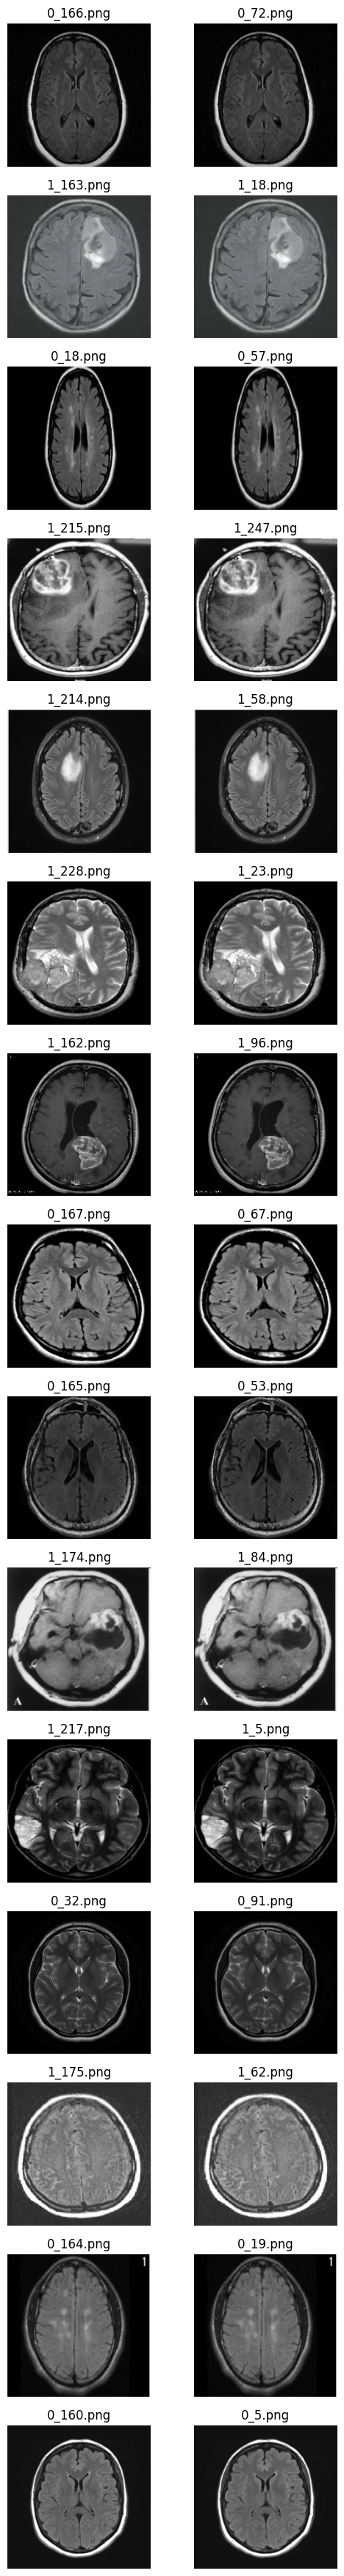

In [8]:
duplicates_pairs_to_show = processor.duplicated_pairs[:30]

fig, axs = plt.subplots(
    nrows=len(duplicates_pairs_to_show) // 2,
    ncols=2,
    figsize=(6, len(duplicates_pairs_to_show) // 2 * 3),
)

for i, pair in enumerate(duplicates_pairs_to_show):
    img1 = load_image_from_filename("data/raw/" + pair[0])
    img2 = load_image_from_filename("data/raw/" + pair[1])

    axs[i // 2, 0].imshow(img1)
    axs[i // 2, 0].axis("off")
    axs[i // 2, 0].set_title(pair[0])

    axs[i // 2, 1].imshow(img2)
    axs[i // 2, 1].axis("off")
    axs[i // 2, 1].set_title(pair[1])

plt.show()

We can observe for each pair, that they the same image, hence we should remove duplicates to avoid data leakage

### Visualizing class distribution

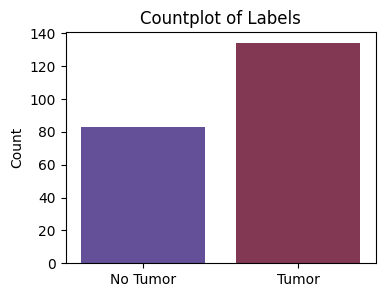

In [9]:
labels_nominal = np.array(["Tumor" if label == 1 else "No Tumor" for label in labels])
plt.figure(figsize=(4, 3))
sns.countplot(x=labels_nominal, hue=labels_nominal, palette="twilight")
plt.title("Countplot of Labels")
plt.ylabel("Count")
plt.show()

Overall, the dataset’s class distribution appears suitable for effective model training, the dataset is relatively balanced.

### Checking pixel intensity statistics

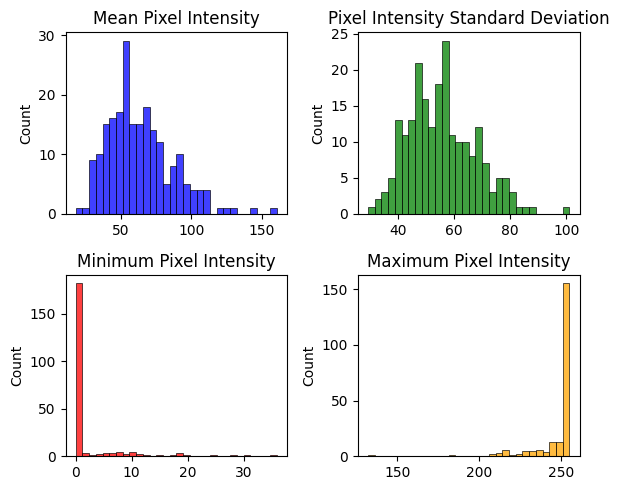

In [10]:
means = []
stds = []
mins = []
maxs = []

for img in images:
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    means.append(np.mean(img_gray))
    stds.append(np.std(img_gray))
    mins.append(np.min(img_gray))
    maxs.append(np.max(img_gray))

fig, axes = plt.subplots(2, 2, figsize=(6, 5))

sns.histplot(means, bins=30, ax=axes[0, 0], color="blue")
axes[0, 0].set_title("Mean Pixel Intensity")

sns.histplot(stds, bins=30, ax=axes[0, 1], color="green")
axes[0, 1].set_title("Pixel Intensity Standard Deviation")

sns.histplot(mins, bins=30, ax=axes[1, 0], color="red")
axes[1, 0].set_title("Minimum Pixel Intensity")

sns.histplot(maxs, bins=30, ax=axes[1, 1], color="orange")
axes[1, 1].set_title("Maximum Pixel Intensity")

plt.tight_layout()
plt.show()

- The mean pixel intensity varies across images, mostly around 50, indicating typical lower brightness levels in brain MRI images.
- The pixel intensity standard deviation is centered around 50-60, reflecting the diverse tissue structures and contrasts in brain MRI scans.
- Minimum pixel intensity is low in all images, mostly close to zero, as expected with dark backgrounds in brain MRIs.
- Maximum pixel intensity is high in all images, mostly close to 255, due to the contrast and nature of MRI.

Overall, there are no signs of artifacts or issues with the images. 

Given the typical intensity distributions and the need for robust model training, applying augmentations will help improve model generalization by providing more diverse training examples.

#### Checking intensities per class

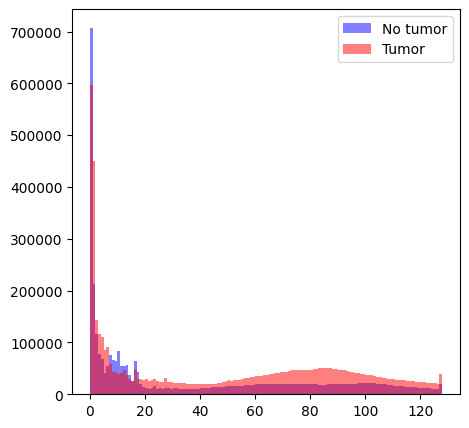

In [24]:
intensities_0 = []
intensities_1 = []

for image, label in zip(images, labels):
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if label == 0:
        intensities_0.extend(image_gray.flatten())
    else:
        intensities_1.extend(image_gray.flatten())

plt.figure(figsize=(5, 5))
plt.hist(
    intensities_0,
    bins=128,
    range=(0, 128),
    color="blue",
    alpha=0.5,
    label="No tumor",
)
plt.hist(intensities_1, bins=128, range=(0, 128), color="red", alpha=0.5, label="Tumor")

plt.legend()
plt.show()

- Both classes (No tumor and Tumor) show many low-intensity values near zero, typical of dark backgrounds in brain MRI images.
- There’s significant overlap in low-intensity ranges between the two classes.
- The Tumor class has a broader distribution of higher intensity values, reflecting the varied intensity of tumor regions.

Overall, the intensity distributions are well-prepared for analysis. Differences in intensity patterns suggest the model can distinguish between classes. Augmentations will improve model robustness and generalization.

### Checking pixel correlation matrix

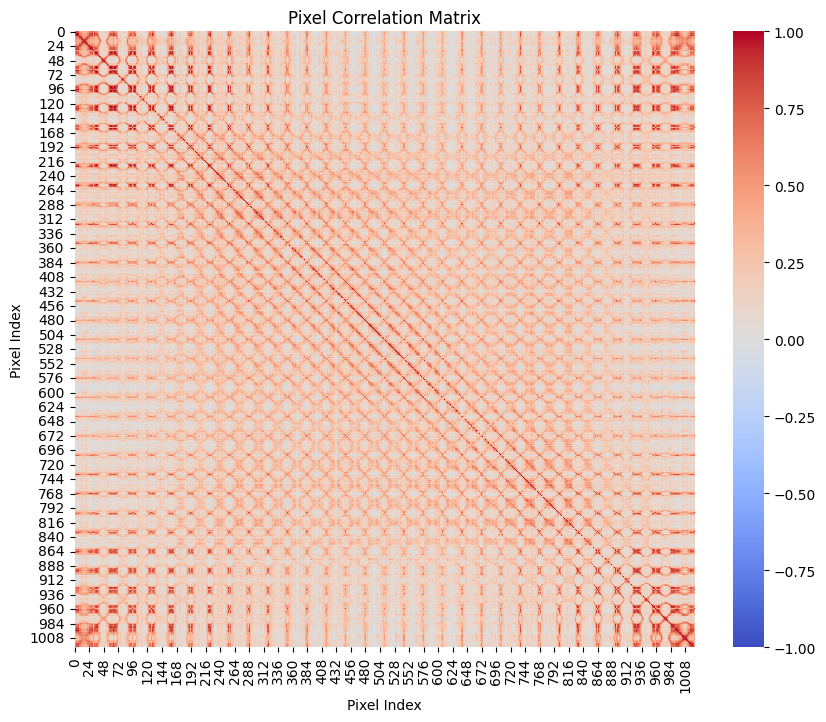

In [25]:
def calculate_pixel_correlations(images):
    gray_images = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images]
    downscaled_images = [cv2.resize(img, (32, 32)) for img in gray_images]
    flattened_images = [img.flatten() for img in downscaled_images]
    data_matrix = np.stack(flattened_images)

    correlation_matrix = np.corrcoef(data_matrix, rowvar=False)

    return correlation_matrix


def plot_pixel_correlations(correlation_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Pixel Correlation Matrix")
    plt.xlabel("Pixel Index")
    plt.ylabel("Pixel Index")
    plt.show()


correlation_matrix = calculate_pixel_correlations(images)
plot_pixel_correlations(correlation_matrix)

- Close pixels exhibit high correlations, indicating typical spatial structure.
- Corners show higher correlations, reflecting the uniform dark background.
- The matrix highlights spatial dependencies and common intensity patterns in MRI images.

### t-SNE dimensionality reduction analysis

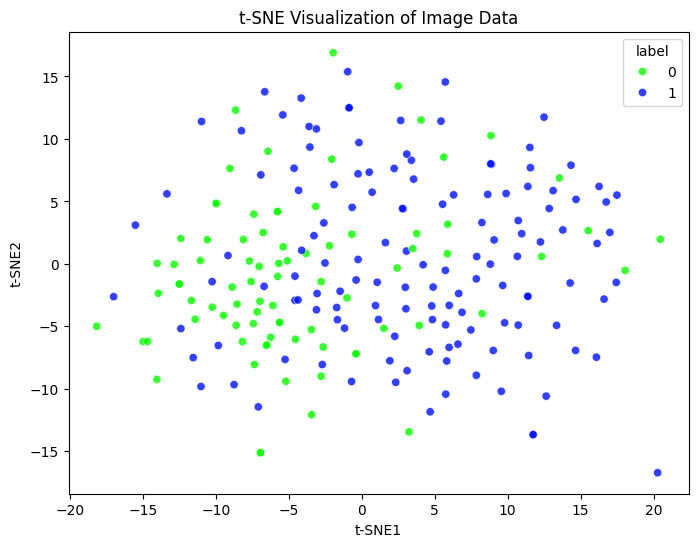

In [26]:
from sklearn.manifold import TSNE

flattened_images = [img.flatten() for img in images]

flattened_images = np.array(flattened_images)

tsne = TSNE(n_components=2, perplexity=30, max_iter=300, random_state=42)
tsne_results = tsne.fit_transform(flattened_images)

df_tsne = pd.DataFrame(tsne_results, columns=["t-SNE1", "t-SNE2"])
df_tsne["label"] = labels

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="t-SNE1",
    y="t-SNE2",
    hue="label",
    palette=sns.color_palette("hsv", len(np.unique(labels))),
    data=df_tsne,
    legend="full",
    alpha=0.8,
)
plt.title("t-SNE Visualization of Image Data")
plt.show()

- Class Separation: Noticeable separation between labels 0 and 1.
- Cluster Density: High-density regions suggest subgroups with similar features.
- Overlap: Some overlap indicates shared features between classes.
- Data Quality: Clear patterns imply good data quality.
- Model Complexity: Advanced models are needed for good differentiation.

### Analyzing Image Blurriness and Sharpness

Using the Variance of the Laplacian

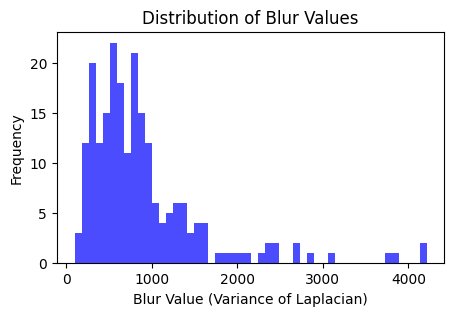

In [27]:
def variance_of_laplacian(image):
    # Compute the Laplacian of the image and return the variance
    return cv2.Laplacian(image, cv2.CV_64F).var()


def analyze_blur(images):
    blur_values = []

    for img in images:
        # Convert image to grayscale if it is in RGB
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img

        # Calculate the blur value
        blur_value = variance_of_laplacian(gray)
        blur_values.append(blur_value)

    return blur_values


def plot_blur_values(blur_values):
    plt.figure(figsize=(5, 3))
    plt.hist(blur_values, bins=50, color="blue", alpha=0.7)
    plt.title("Distribution of Blur Values")
    plt.xlabel("Blur Value (Variance of Laplacian)")
    plt.ylabel("Frequency")
    plt.show()


blur_values = analyze_blur(images)
plot_blur_values(blur_values)

#### Display the most blurry images

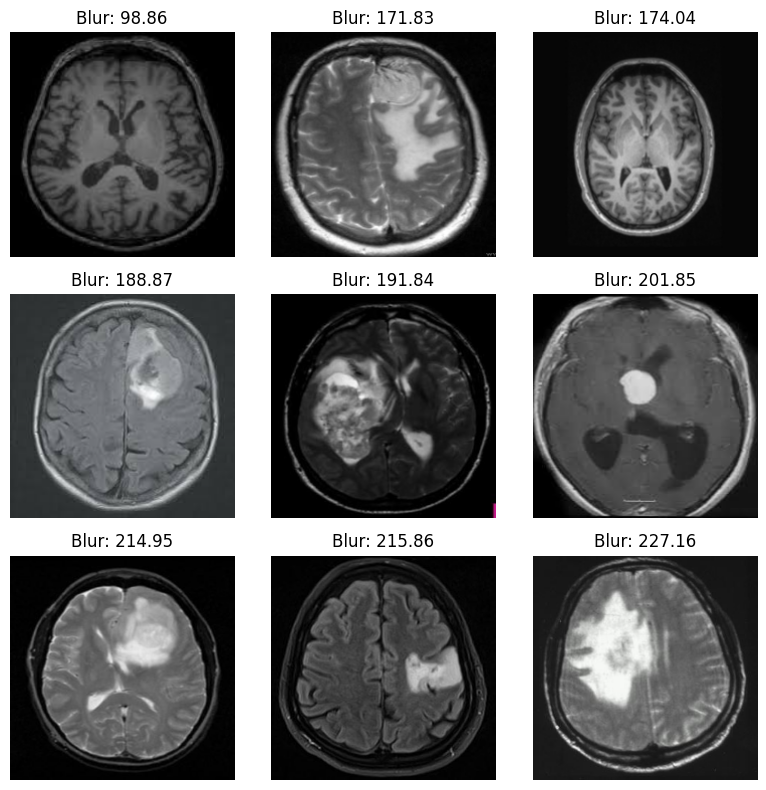

In [33]:
sorted_indices = np.argsort(blur_values)[::1]
images_numpy = np.array(images)
images_sorted = images_numpy[sorted_indices]

fig, axs = plt.subplots(3, 3, figsize=(8, 8))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(images_sorted[i])
    ax.axis("off")
    ax.set_title(f"Blur: {blur_values[sorted_indices[i]]:.2f}")

plt.tight_layout()
plt.show()

The most blurry images obtained from the variance of the Laplacian are acceptable. They show patterns clear enough to identify the presence of a tumor, so we can safely use all of them.